# test-wavelet-1.ipynb

Continuous Wavelet Transform of a one-dimensional signal:  

    pywt.cwt(data, scales, wavelet)
    
    Parameters:
        data                array_like                  input signal
        scales              array_like                  can provide pywt.frequency2scale(wavelet, frequencies)  (freqs normalized by fs_Hz)
        wavelet             Wavelet object              name string
        sampling_period     float                       optional but shouldn't be:  provide sampling_period in seconds to get freq in Hz.
        method              {‘conv’, ‘fft’}             optional:   conv uses numpy.convolve, fft uses frequency domain convolution,
                                                                    auto uses estimate of the computational complexity to choose at each scale.
        axis                int                         optional:   if not given, the last axis is used.
    Returns:
        coefs               array_like                  Continuous wavelet transform of signal for given scales and wavelet. 
                                                        The coefs are independent of (not scaled by) the  sampling_period
                                                        The first axis of coefs corresponds to the scales. 
                                                        The remaining axes match the shape of data.
        frequencies         array_like                  Frequencies are in Hz when sampling period is in seconds.
                                                        Otherwise, a sampling period of 1 is assumed, which is nonsense.


To determine available continuous wavelets: print(pywt.wavelist(kind='continuous')) eg:   
    'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 
    'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan'
mexh: mexican hat
morl: morlet
cmorB-C: complex morlet ???
gausX: gaussian derivative
cgauX: complex gaussian derivative
shanB-C: shannon ???
fbspB-C: frequency B-spline ???

For cmor, fbsp and shan wavelets, specify a normalized center frequency. A value of 1.0 corresponds to 1/dt_secs where dt_secs is the sampling period.  

The scales determine the frequency resolution of the scaleogram.  PyWavelets evaluates the wavelet function over the range 
[wavelet.lower_bound, wavelet.upper_bound] (with default range [-8,8]). For scale = 1 the extent of the wavelet is 
(wavelet.upper_bound - wavelet.lower_bound + 1) samples of the digital signal being analyzed. Larger scales correspond to stretching of the wavelet. For example, at scale=10 the wavelet is stretched by a factor of 10, making it sensitive to lower frequencies in the signal.

Note: If scale is too low, this will result in a discrete filter that is inadequately sampled leading to aliasing.
The proper choice of scales depends on the chosen wavelet, so pywt.scale2frequency() should be used to get an idea of an appropriate range for the signal of interest.

Example: for a signal sampled at 100 Hz, a center frequency of 1.0 corresponds to ~100 Hz at scale = 1.  
This is above the Nyquist rate of 50 Hz, so for this particular wavelet, one would analyze a signal using scales >= 2.

Note: the raw output of cwt is complex if a complex wavelet is used. For visualization, it is therefore necessary to use the absolute value.

Convert scales to freqs:
frequencies = pywt.scale2frequency(wavelet, scale)/sampling_period

Convert freqs to scales:
frequencies = np.array([100, 50, 33.33333333, 25]) / fs_Hz    # must normalize
scale = pywt.frequency2scale(wavelet, frequencies)


# Chirp signal: continuous complex morlet, rfft (log scale), and pcolormesh

from: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#choosing-scales

Generate a chirp signal using the sum of two sine functions with increasing frequency, and plot the signal and the two time-dependent frequency components it contains.  Use Continuous Wavelet Transform using a complex Morlet wavlet with a given center frequency and bandwidth (namely cmor1.5-1.0). Scaleogram scales (widths) are on a logarithmic scale for freq plots. 

[100.          50.          33.33333333  25.        ]


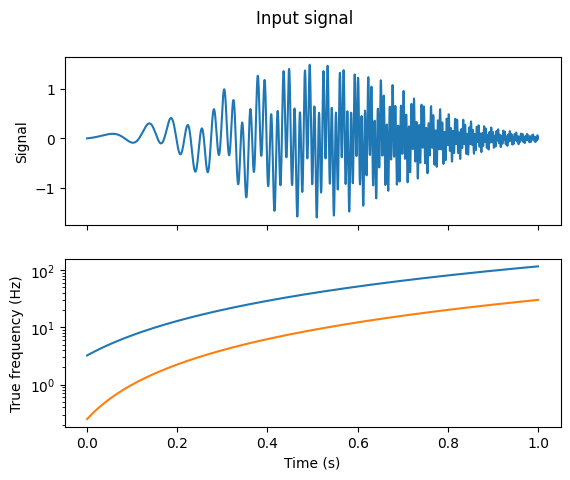

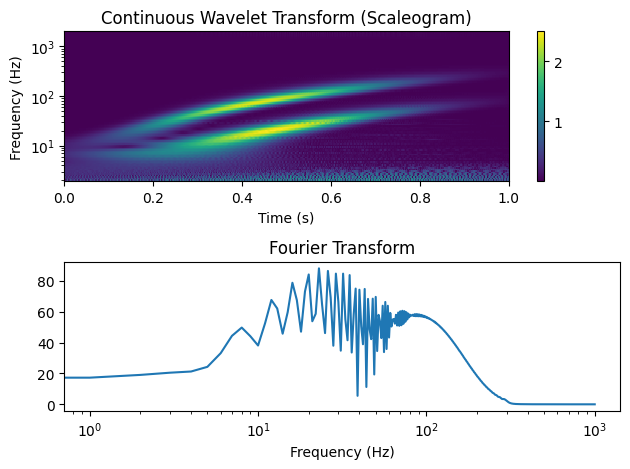

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import pywt


def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)

def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency

dt_secs = 0.01  # 100 Hz sampling
frequencies = pywt.scale2frequency('cmor1.5-1.0', [1, 2, 3, 4]) / dt_secs
print(frequencies)

# generate signal
time = np.linspace(0, 1, 2000)
chirp1, frequency1 = make_chirp(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + (0.6 * chirp2)
chirp *= gaussian(time, 0.5, 0.2)

# plot signal
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, chirp)
axs[1].plot(time, frequency1)
axs[1].plot(time, frequency2)
axs[1].set_yscale("log")
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Signal")
axs[1].set_ylabel("True frequency (Hz)")
plt.suptitle("Input signal")
plt.show()

# perform CWT
wavelet = "cmor1.5-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(chirp, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(chirp)
xf = rfftfreq(len(chirp), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()


# Wavelet bandwidth and center frequencies, with pcolormesh

from: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#choosing-scales

The Complex Morlet Wavelet can be configured for optimum results using the center_frequency and bandwidth_frequency parameters, which can simply be appended to the wavelet’s string identifier cmor for convenience. It also demonstrates the importance of choosing appropriate values for the wavelet’s center frequency and bandwidth. The right values will depend on the signal being analyzed. As shown below, bad values may lead to poor resolution or artifacts.

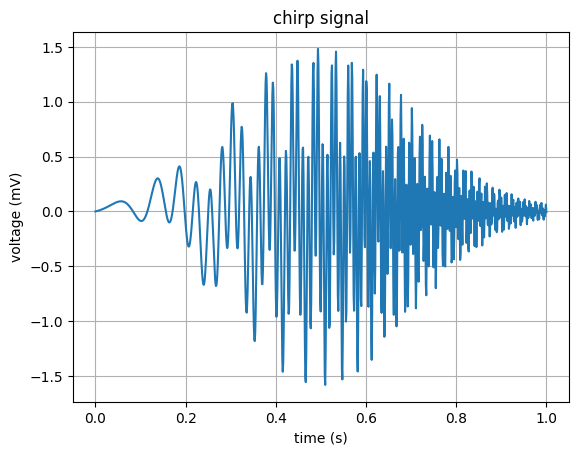

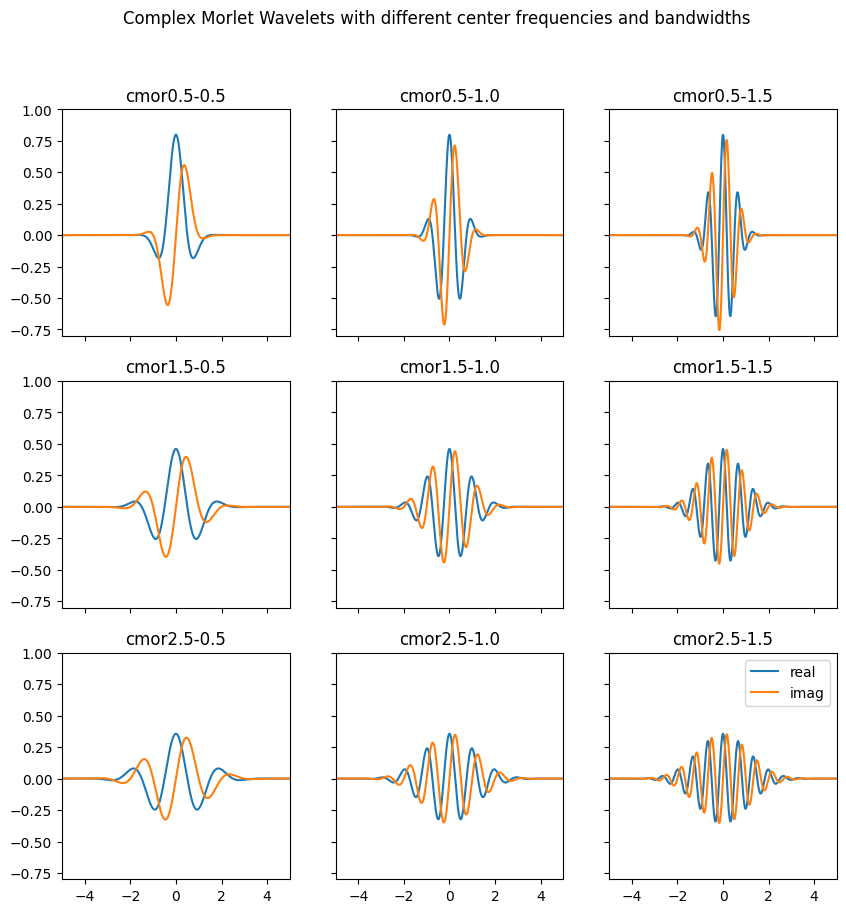

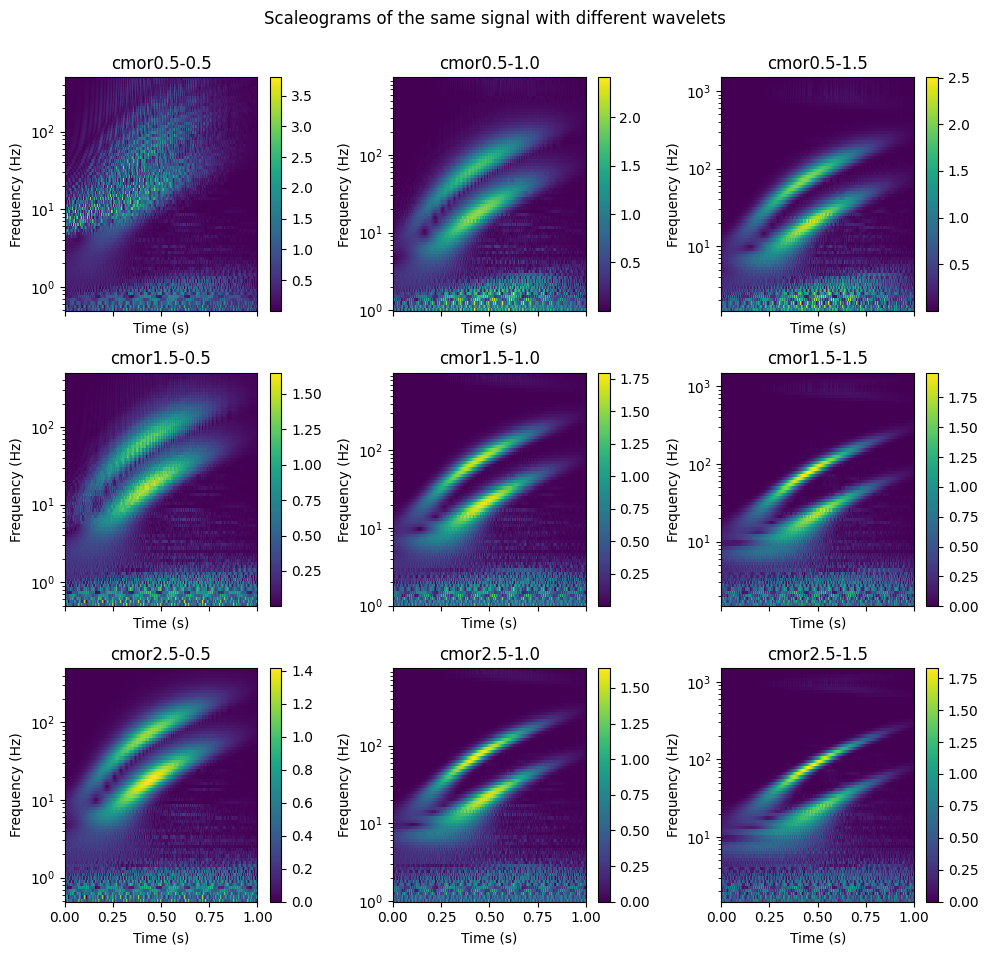

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import pywt

def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency


def plot_wavelet(time, data, wavelet, title, ax):
    widths = np.geomspace(1, 1024, num=75)
    cwtmatr, freqs = pywt.cwt(
        data, widths, wavelet, sampling_period=np.diff(time).mean()
    )
    cwtmatr = np.abs(cwtmatr[:-1, :-1])
    pcm = ax.pcolormesh(time, freqs, cwtmatr)
    ax.set_yscale("log")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(title)
    plt.colorbar(pcm, ax=ax)
    return ax


# generate signal
time = np.linspace(0, 1, 1000)
chirp1, frequency1 = make_chirp(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + 0.6 * chirp2
chirp *= gaussian(time, 0.5, 0.2)

# plot signal
_, ax = plt.subplots()
ax.plot(time, chirp)
ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='chirp signal')
ax.grid()
plt.show()

# plot complex morlet wavelets with different center frequencies and bandwidths
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real")
    ax.plot(x, np.imag(psi), label="imag")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.8, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with different center frequencies and bandwidths")
plt.show()

# perform CWT with different wavelets on same signal and plot results
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    plot_wavelet(time, chirp, wavelet, wavelet, ax)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Scaleograms of the same signal with different wavelets")
plt.show()


# Continuous Wavelet Families

from: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#choosing-scales

Wavelets can be customized by passing parameters such as center_frequency and bandwidth_frequency 

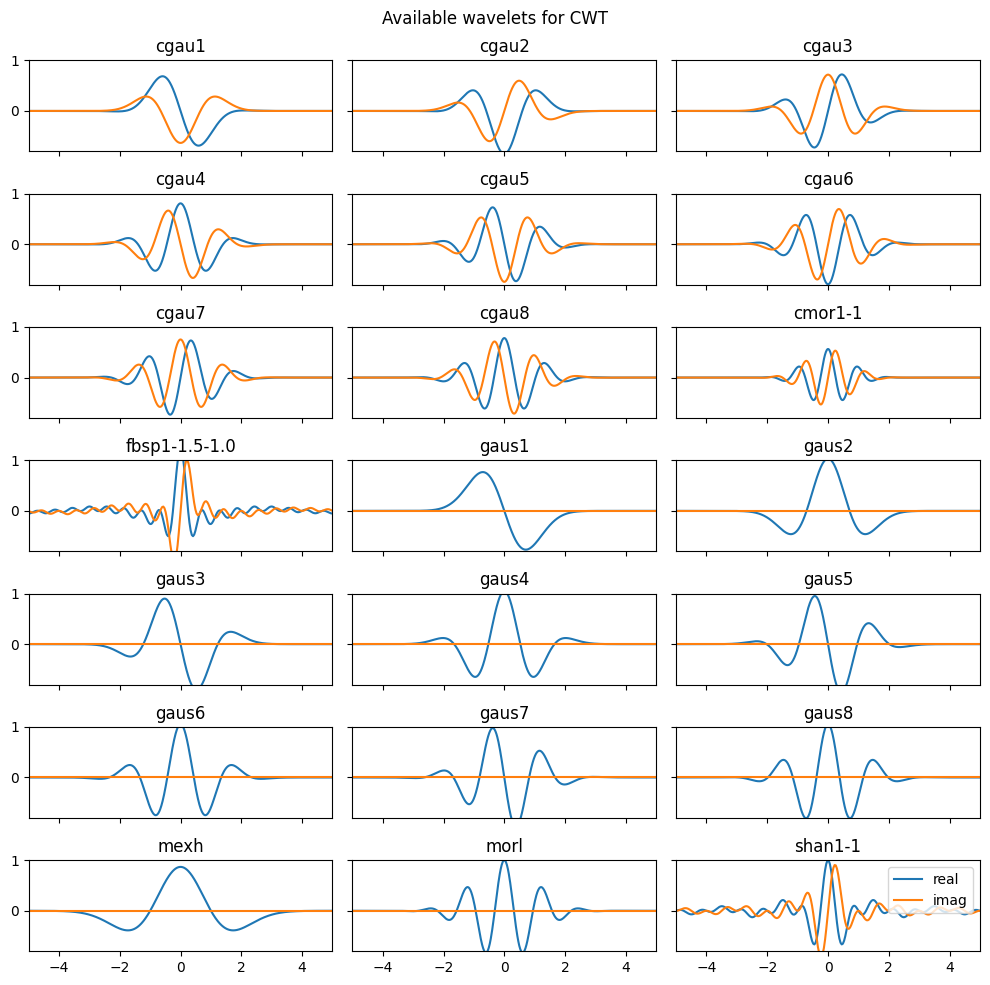

In [6]:
import matplotlib.pyplot as plt
import numpy as np

import pywt

wavlist = pywt.wavelist(kind="continuous")
cols = 3
rows = (len(wavlist) + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(10, 10),
                        sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavlist):
    # A few wavelet families require parameters in the string name
    if wavelet in ['cmor', 'shan']:
        wavelet += '1-1'
    elif wavelet == 'fbsp':
        wavelet += '1-1.5-1.0'

    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real")
    ax.plot(x, np.imag(psi), label="imag")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.8, 1])

ax.legend(loc="upper right")
plt.suptitle("Available wavelets for CWT")
plt.tight_layout()
plt.show()


# Plot a wavelet at differing scales and show fft of said wavelet

from: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#choosing-scales


Continuous wavelet will be evaluated over the range [-8.0, 8.0]


Text(0.5, 1.0, '|FFT(filter)|$^2$')

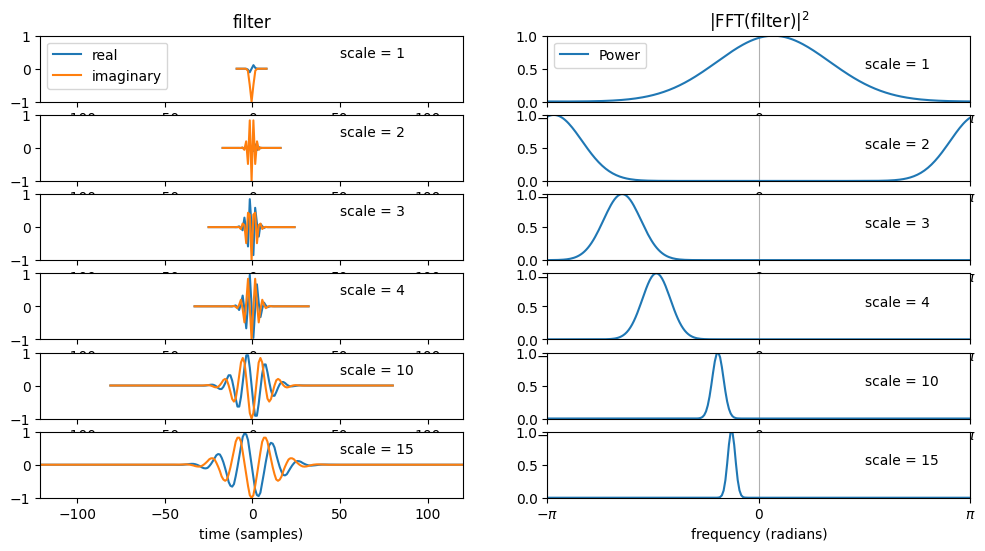

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import pywt

wav = pywt.ContinuousWavelet('cmor1.5-1.0')

# print the range over which the wavelet will be evaluated
print("Continuous wavelet will be evaluated over the range "
      f"[{wav.lower_bound}, {wav.upper_bound}]")

width = wav.upper_bound - wav.lower_bound

scales = [1, 2, 3, 4, 10, 15]

max_len = int(np.max(scales)*width + 1)
t = np.arange(max_len)
fig, axes = plt.subplots(len(scales), 2, figsize=(12, 6))
for n, scale in enumerate(scales):

    # The following code is adapted from the internals of cwt
    int_psi, x = pywt.integrate_wavelet(wav, precision=10)
    step = x[1] - x[0]
    j = np.floor(
        np.arange(scale * width + 1) / (scale * step))
    if np.max(j) >= np.size(int_psi):
        j = np.delete(j, np.where(j >= np.size(int_psi))[0])
    j = j.astype(np.int_)

    # normalize int_psi for easier plotting
    int_psi /= np.abs(int_psi).max()

    # discrete samples of the integrated wavelet
    filt = int_psi[j][::-1]

    # The CWT consists of convolution of filt with the signal at this scale
    # Here we plot this discrete convolution kernel at each scale.

    nt = len(filt)
    t = np.linspace(-nt//2, nt//2, nt)
    axes[n, 0].plot(t, filt.real, t, filt.imag)
    axes[n, 0].set_xlim([-max_len//2, max_len//2])
    axes[n, 0].set_ylim([-1, 1])
    axes[n, 0].text(50, 0.35, f'scale = {scale}')

    f = np.linspace(-np.pi, np.pi, max_len)
    filt_fft = np.fft.fftshift(np.fft.fft(filt, n=max_len))
    filt_fft /= np.abs(filt_fft).max()
    axes[n, 1].plot(f, np.abs(filt_fft)**2)
    axes[n, 1].set_xlim([-np.pi, np.pi])
    axes[n, 1].set_ylim([0, 1])
    axes[n, 1].set_xticks([-np.pi, 0, np.pi])
    axes[n, 1].set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
    axes[n, 1].grid(True, axis='x')
    axes[n, 1].text(np.pi/2, 0.5, f'scale = {scale}')

axes[n, 0].set_xlabel('time (samples)')
axes[n, 1].set_xlabel('frequency (radians)')
axes[0, 0].legend(['real', 'imaginary'], loc='upper left')
axes[0, 1].legend(['Power'], loc='upper left')
axes[0, 0].set_title('filter')
axes[0, 1].set_title(r'|FFT(filter)|$^2$')
